In [ ]:
import pandas as pd
import random

# Load with on_bad_lines='skip' to ignore malformed rows
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", 
                 on_bad_lines='skip')

print(f"Loaded {len(df)} records")
print(f"\nAll columns ({len(df.columns)}):")
print(df.columns.tolist())

Loaded 82608 records

All columns (73):
['match_id', 'player_id', 'name', 'team', 'position', 'shirt_number', 'fotmob_rating', 'minutes_played', 'goals', 'assists', 'total_shots', 'shotmap', 'accurate_passes', 'chances_created', 'expected_assists_(xa)', 'xg_+_xa', 'fantasy_points', 'defensive_actions', 'touches', 'touches_in_opposition_box', 'passes_into_final_third', 'accurate_crosses', 'accurate_long_balls', 'dispossessed', 'tackles', 'blocks', 'clearances', 'headed_clearance', 'interceptions', 'recoveries', 'dribbled_past', 'duels_won', 'duels_lost', 'ground_duels_won', 'aerial_duels_won', 'was_fouled', 'fouls_committed', 'season', 'expected_goals_(xg)', 'expected_goals_on_target_(xgot)', 'shots_on_target', 'big_chances_missed', 'xg_non-penalty', 'blocked_shots', 'successful_dribbles', 'saves', 'goals_conceded', 'xgot_faced', 'goals_prevented', 'acted_as_sweeper', 'high_claim', 'diving_save', 'saves_inside_box', 'punches', 'throws', 'corners', 'offsides', 'error_led_to_goal', 'conce

Comparing against 103 MIDs with 450+ minutes


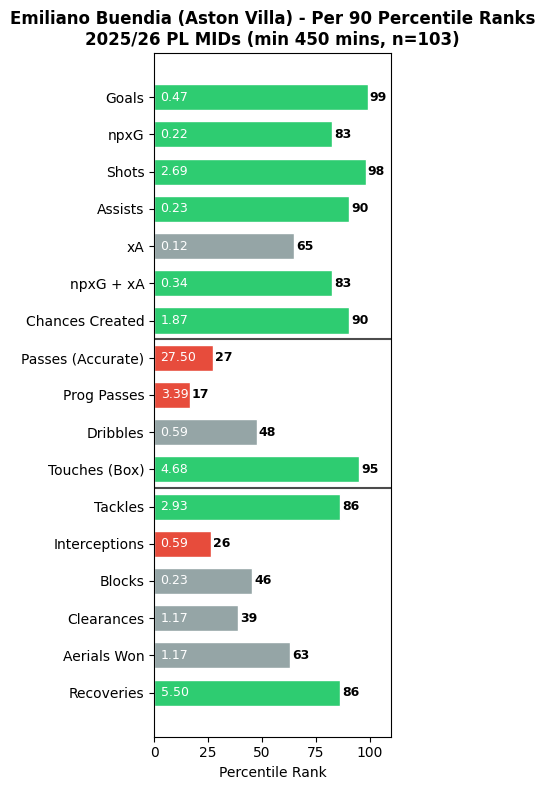


Emiliano Buendia - Per 90 Stats (vs MIDs):
Minutes: 769
  Goals: 0.47
  npxG: 0.22
  Shots: 2.69
  Assists: 0.23
  xA: 0.12
  npxG + xA: 0.34
  Chances Created: 1.87
  Passes (Accurate): 27.50
  Prog Passes: 3.39
  Dribbles: 0.59
  Touches (Box): 4.68
  Tackles: 2.93
  Interceptions: 0.59
  Blocks: 0.23
  Clearances: 1.17
  Aerials Won: 1.17
  Recoveries: 5.50


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to current season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
agg_cols = {
    'minutes_played': 'sum',
    'goals': 'sum',
    'xg_non-penalty': 'sum',
    'total_shots': 'sum',
    'assists': 'sum',
    'expected_assists_(xa)': 'sum',
    'chances_created': 'sum',
    'accurate_passes': 'sum',
    'passes_into_final_third': 'sum',
    'successful_dribbles': 'sum',
    'touches_in_opposition_box': 'sum',
    'tackles': 'sum',
    'interceptions': 'sum',
    'blocks': 'sum',
    'clearances': 'sum',
    'aerial_duels_won': 'sum',
    'recoveries': 'sum',
}

player_totals = df_season.groupby(['player_id', 'name', 'team', 'position']).agg(agg_cols).reset_index()

# Filter to players with at least 450 minutes
player_totals = player_totals[player_totals['minutes_played'] >= 450].copy()

# Calculate per 90 stats
per90_cols = [c for c in agg_cols.keys() if c != 'minutes_played']
for col in per90_cols:
    player_totals[f'{col}_p90'] = player_totals[col] / player_totals['minutes_played'] * 90

# Calculate npxG + xA per 90
player_totals['npxg_xa_p90'] = player_totals['xg_non-penalty_p90'] + player_totals['expected_assists_(xa)_p90']

# Stats config
stats_config = {
    'Goals': 'goals_p90',
    'npxG': 'xg_non-penalty_p90',
    'Shots': 'total_shots_p90',
    'Assists': 'assists_p90',
    'xA': 'expected_assists_(xa)_p90',
    'npxG + xA': 'npxg_xa_p90',
    'Chances Created': 'chances_created_p90',
    'Passes (Accurate)': 'accurate_passes_p90',
    'Prog Passes': 'passes_into_final_third_p90',
    'Dribbles': 'successful_dribbles_p90',
    'Touches (Box)': 'touches_in_opposition_box_p90',
    'Tackles': 'tackles_p90',
    'Interceptions': 'interceptions_p90',
    'Blocks': 'blocks_p90',
    'Clearances': 'clearances_p90',
    'Aerials Won': 'aerial_duels_won_p90',
    'Recoveries': 'recoveries_p90',
}

# Get player's data first to find position
player_name = 'Emiliano Buendia'
player_data = player_totals[player_totals['name'] == player_name]

if len(player_data) == 0:
    print(f"Player '{player_name}' not found.")
else:
    player_row = player_data.iloc[0]
    player_position = player_row['position']
    
    # Filter to only players with same position
    position_df = player_totals[player_totals['position'] == player_position].copy()
    position_count = len(position_df)
    
    # Map position number to name
    position_names = {0: 'GK', 1: 'DEF', 2: 'MID', 3: 'FWD'}
    position_name = position_names.get(player_position, f'Position {player_position}')
    
    print(f"Comparing against {position_count} {position_name}s with 450+ minutes")
    
    # Calculate percentile ranks within same position
    for stat_name, col in stats_config.items():
        position_df[f'{col}_pct'] = position_df[col].rank(pct=True) * 100
    
    # Get updated player row
    player_row = position_df[position_df['name'] == player_name].iloc[0]
    
    # Extract percentiles
    labels = list(stats_config.keys())
    percentiles = [player_row[f'{col}_pct'] for col in stats_config.values()]
    
    # Color function
    def get_color(pct):
        if pct >= 66:
            return '#2ecc71'  # green
        elif pct >= 33:
            return '#95a5a6'  # gray
        else:
            return '#e74c3c'  # red
    
    colors = [get_color(p) for p in percentiles]
    
    # Get actual values for display
    actual_values = [player_row[col] for col in stats_config.values()]
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(4, 8))
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, percentiles, color=colors, edgecolor='white', height=0.7)
    
    # Add percentile and actual value labels
    for i, (bar, pct, val) in enumerate(zip(bars, percentiles, actual_values)):
        ax.text(pct + 1, i, f'{pct:.0f}', va='center', ha='left', fontsize=9, fontweight='bold')
        ax.text(3, i, f'{val:.2f}', va='center', ha='left', fontsize=9, color='white')
    
    # Add horizontal separators between sections
    # Section 1: Goals to Chances Created (indices 0-6)
    # Section 2: Passes to Touches Box (indices 7-10)
    # Section 3: Tackles to Aerials Won (indices 11-15)
    ax.axhline(y=6.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhline(y=10.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Percentile Rank')
    ax.set_xlim(0, 110)
    ax.set_title(f"{player_name} ({player_row['team']}) - Per 90 Percentile Ranks\n2025/26 PL {position_name}s (min 450 mins, n={position_count})", fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{player_name} - Per 90 Stats (vs {position_name}s):")
    print(f"Minutes: {player_row['minutes_played']:.0f}")
    for stat_name, col in stats_config.items():
        print(f"  {stat_name}: {player_row[col]:.2f}")

In [5]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to 2025-2026 season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
player_stats = df_season.groupby(['player_id', 'name', 'team']).agg({
    'minutes_played': 'sum',
    'expected_goals_(xg)': 'sum',
    'expected_assists_(xa)': 'sum',
    'xg_non-penalty': 'sum',
}).reset_index()

# Filter players with at least 450 minutes
player_stats = player_stats[player_stats['minutes_played'] >= 450].copy()

# Calculate per 90 stats
player_stats['xg_per_90'] = (player_stats['expected_goals_(xg)'] / player_stats['minutes_played']) * 90
player_stats['xa_per_90'] = (player_stats['expected_assists_(xa)'] / player_stats['minutes_played']) * 90
player_stats['npxg_per_90'] = (player_stats['xg_non-penalty'] / player_stats['minutes_played']) * 90
player_stats['npxg_xa_per_90'] = player_stats['npxg_per_90'] + player_stats['xa_per_90']

# Sort by npxG+xA per 90 and get top 25
top_25 = player_stats.nlargest(25, 'npxg_xa_per_90')[['name', 'team', 'minutes_played', 'npxg_xa_per_90', 'xg_per_90', 'xa_per_90', 'npxg_per_90']].copy()

# Round stats for readability
top_25['xg_per_90'] = top_25['xg_per_90'].round(2)
top_25['xa_per_90'] = top_25['xa_per_90'].round(2)
top_25['npxg_per_90'] = top_25['npxg_per_90'].round(2)
top_25['npxg_xa_per_90'] = top_25['npxg_xa_per_90'].round(2)

# Rename columns for display
top_25.columns = ['Player', 'Team', 'Minutes', 'npxG+xA/90', 'xG/90', 'xA/90', 'npxG/90']

# Reset index for display
top_25 = top_25.reset_index(drop=True)
top_25.index = top_25.index + 1

print("Top 25 Players by npxG+xA per 90 (2025-26, min 450 mins)")
display(top_25)

Top 25 Players by npxG+xA per 90 (2025-26, min 450 mins)


,Player,Team,Minutes,npxG+xA/90,xG/90,xA/90,npxG/90
1,Erling Haaland,Manchester City,1906.0,0.83,0.88,0.07,0.77
2,Rayan Cherki,Manchester City,886.0,0.71,0.17,0.54,0.17
3,David Brooks,Bournemouth,942.0,0.69,0.42,0.27,0.42
4,Estevao,Chelsea,604.0,0.67,0.35,0.32,0.35
5,Donyell Malen,Aston Villa,645.0,0.61,0.56,0.05,0.56
6,Hugo Ekitike,Liverpool,1227.0,0.61,0.47,0.13,0.47
7,Bryan Mbeumo,Manchester United,1475.0,0.60,0.39,0.21,0.39
8,Bukayo Saka,Arsenal,1459.0,0.58,0.34,0.29,0.29
9,Harvey Barnes,Newcastle United,1039.0,0.55,0.39,0.16,0.39
10,Enzo Fernández,Chelsea,1788.0,0.55,0.39,0.20,0.35


In [4]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to 2025-2026 season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
player_stats = df_season.groupby(['player_id', 'name', 'team']).agg({
    'minutes_played': 'sum',
    'expected_goals_(xg)': 'sum',
    'expected_assists_(xa)': 'sum',
    'xg_non-penalty': 'sum',
}).reset_index()

# Calculate npxG + xA (non-penalty xG + xA)
player_stats['npxg_plus_xa'] = player_stats['xg_non-penalty'] + player_stats['expected_assists_(xa)']

# Filter players with at least 450 minutes
player_stats = player_stats[player_stats['minutes_played'] >= 450].copy()

# Calculate per 90 stats
player_stats['xg_per_90'] = (player_stats['expected_goals_(xg)'] / player_stats['minutes_played']) * 90
player_stats['xa_per_90'] = (player_stats['expected_assists_(xa)'] / player_stats['minutes_played']) * 90
player_stats['npxg_per_90'] = (player_stats['xg_non-penalty'] / player_stats['minutes_played']) * 90

# Sort by npxG + xA and get top 25
top_25 = player_stats.nlargest(25, 'npxg_plus_xa')[['name', 'team', 'minutes_played', 'npxg_plus_xa', 'xg_per_90', 'xa_per_90', 'npxg_per_90']].copy()

# Round stats for readability
top_25['xg_per_90'] = top_25['xg_per_90'].round(2)
top_25['xa_per_90'] = top_25['xa_per_90'].round(2)
top_25['npxg_per_90'] = top_25['npxg_per_90'].round(2)
top_25['npxg_plus_xa'] = top_25['npxg_plus_xa'].round(2)

# Rename columns for display
top_25.columns = ['Player', 'Team', 'Minutes', 'npxG+xA', 'xG/90', 'xA/90', 'npxG/90']

# Reset index for display
top_25 = top_25.reset_index(drop=True)
top_25.index = top_25.index + 1

display(top_25)

,Player,Team,Minutes,npxG+xA,xG/90,xA/90,npxG/90
1,Erling Haaland,Manchester City,1906.0,17.68,0.88,0.07,0.77
2,Enzo Fernández,Chelsea,1788.0,10.96,0.39,0.20,0.35
3,Jean-Philippe Mateta,Crystal Palace,1829.0,10.38,0.57,0.06,0.45
4,Bryan Mbeumo,Manchester United,1475.0,9.78,0.39,0.21,0.39
5,Bruno Fernandes,Manchester United,1627.0,9.47,0.39,0.31,0.21
6,Ollie Watkins,Aston Villa,1661.0,9.40,0.46,0.05,0.46
7,Bukayo Saka,Arsenal,1459.0,9.40,0.34,0.29,0.29
8,Kevin Schade,Brentford,1733.0,9.03,0.43,0.08,0.39
9,Igor Thiago,Brentford,1844.0,8.88,0.62,0.04,0.39
10,Phil Foden,Manchester City,1615.0,8.55,0.28,0.19,0.28


In [3]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to 2025-2026 season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
player_stats = df_season.groupby(['player_id', 'name', 'team']).agg({
    'minutes_played': 'sum',
    'expected_goals_(xg)': 'sum',
    'expected_assists_(xa)': 'sum',
    'xg_non-penalty': 'sum',
}).reset_index()

# Calculate total xG + xA
player_stats['xg_plus_xa'] = player_stats['expected_goals_(xg)'] + player_stats['expected_assists_(xa)']

# Filter players with at least 450 minutes
player_stats = player_stats[player_stats['minutes_played'] >= 450].copy()

# Calculate per 90 stats
player_stats['xg_per_90'] = (player_stats['expected_goals_(xg)'] / player_stats['minutes_played']) * 90
player_stats['xa_per_90'] = (player_stats['expected_assists_(xa)'] / player_stats['minutes_played']) * 90
player_stats['npxg_per_90'] = (player_stats['xg_non-penalty'] / player_stats['minutes_played']) * 90

# Sort by xG + xA and get top 25
top_25 = player_stats.nlargest(25, 'xg_plus_xa')[['name', 'team', 'minutes_played', 'xg_plus_xa', 'xg_per_90', 'xa_per_90', 'npxg_per_90']].copy()

# Round per-90 stats for readability
top_25['xg_per_90'] = top_25['xg_per_90'].round(2)
top_25['xa_per_90'] = top_25['xa_per_90'].round(2)
top_25['npxg_per_90'] = top_25['npxg_per_90'].round(2)
top_25['xg_plus_xa'] = top_25['xg_plus_xa'].round(2)

# Rename columns for display
top_25.columns = ['Player', 'Team', 'Minutes', 'xG+xA', 'xG/90', 'xA/90', 'npxG/90']

# Reset index for display
top_25 = top_25.reset_index(drop=True)
top_25.index = top_25.index + 1

display(top_25)

,Player,Team,Minutes,xG+xA,xG/90,xA/90,npxG/90
1,Erling Haaland,Manchester City,1906.0,20.05,0.88,0.07,0.77
2,Igor Thiago,Brentford,1844.0,13.62,0.62,0.04,0.39
3,Jean-Philippe Mateta,Crystal Palace,1829.0,12.75,0.57,0.06,0.45
4,Bruno Fernandes,Manchester United,1627.0,12.63,0.39,0.31,0.21
5,Enzo Fernández,Chelsea,1788.0,11.75,0.39,0.20,0.35
6,Bukayo Saka,Arsenal,1459.0,10.19,0.34,0.29,0.29
7,Kevin Schade,Brentford,1733.0,9.82,0.43,0.08,0.39
8,Bryan Mbeumo,Manchester United,1475.0,9.78,0.39,0.21,0.39
9,Ollie Watkins,Aston Villa,1661.0,9.40,0.46,0.05,0.46
10,Dominic Calvert-Lewin,Leeds United,1404.0,9.08,0.52,0.06,0.42


Comparing against 103 MIDs with 450+ minutes


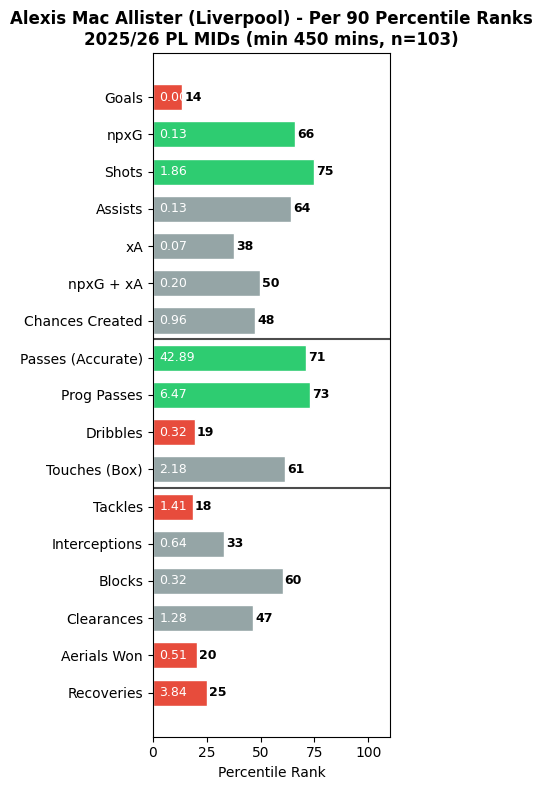


Alexis Mac Allister - Per 90 Stats (vs MIDs):
Minutes: 1406
  Goals: 0.00
  npxG: 0.13
  Shots: 1.86
  Assists: 0.13
  xA: 0.07
  npxG + xA: 0.20
  Chances Created: 0.96
  Passes (Accurate): 42.89
  Prog Passes: 6.47
  Dribbles: 0.32
  Touches (Box): 2.18
  Tackles: 1.41
  Interceptions: 0.64
  Blocks: 0.32
  Clearances: 1.28
  Aerials Won: 0.51
  Recoveries: 3.84


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to current season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
agg_cols = {
    'minutes_played': 'sum',
    'goals': 'sum',
    'xg_non-penalty': 'sum',
    'total_shots': 'sum',
    'assists': 'sum',
    'expected_assists_(xa)': 'sum',
    'chances_created': 'sum',
    'accurate_passes': 'sum',
    'passes_into_final_third': 'sum',
    'successful_dribbles': 'sum',
    'touches_in_opposition_box': 'sum',
    'tackles': 'sum',
    'interceptions': 'sum',
    'blocks': 'sum',
    'clearances': 'sum',
    'aerial_duels_won': 'sum',
    'recoveries': 'sum',
}

player_totals = df_season.groupby(['player_id', 'name', 'team', 'position']).agg(agg_cols).reset_index()

# Filter to players with at least 450 minutes
player_totals = player_totals[player_totals['minutes_played'] >= 450].copy()

# Calculate per 90 stats
per90_cols = [c for c in agg_cols.keys() if c != 'minutes_played']
for col in per90_cols:
    player_totals[f'{col}_p90'] = player_totals[col] / player_totals['minutes_played'] * 90

# Calculate npxG + xA per 90
player_totals['npxg_xa_p90'] = player_totals['xg_non-penalty_p90'] + player_totals['expected_assists_(xa)_p90']

# Stats config
stats_config = {
    'Goals': 'goals_p90',
    'npxG': 'xg_non-penalty_p90',
    'Shots': 'total_shots_p90',
    'Assists': 'assists_p90',
    'xA': 'expected_assists_(xa)_p90',
    'npxG + xA': 'npxg_xa_p90',
    'Chances Created': 'chances_created_p90',
    'Passes (Accurate)': 'accurate_passes_p90',
    'Prog Passes': 'passes_into_final_third_p90',
    'Dribbles': 'successful_dribbles_p90',
    'Touches (Box)': 'touches_in_opposition_box_p90',
    'Tackles': 'tackles_p90',
    'Interceptions': 'interceptions_p90',
    'Blocks': 'blocks_p90',
    'Clearances': 'clearances_p90',
    'Aerials Won': 'aerial_duels_won_p90',
    'Recoveries': 'recoveries_p90',
}

# Get player's data first to find position
player_name = 'Alexis Mac Allister'
player_data = player_totals[player_totals['name'] == player_name]

if len(player_data) == 0:
    print(f"Player '{player_name}' not found.")
else:
    player_row = player_data.iloc[0]
    player_position = player_row['position']
    
    # Filter to only players with same position
    position_df = player_totals[player_totals['position'] == player_position].copy()
    position_count = len(position_df)
    
    # Map position number to name
    position_names = {0: 'GK', 1: 'DEF', 2: 'MID', 3: 'FWD'}
    position_name = position_names.get(player_position, f'Position {player_position}')
    
    print(f"Comparing against {position_count} {position_name}s with 450+ minutes")
    
    # Calculate percentile ranks within same position
    for stat_name, col in stats_config.items():
        position_df[f'{col}_pct'] = position_df[col].rank(pct=True) * 100
    
    # Get updated player row
    player_row = position_df[position_df['name'] == player_name].iloc[0]
    
    # Extract percentiles
    labels = list(stats_config.keys())
    percentiles = [player_row[f'{col}_pct'] for col in stats_config.values()]
    
    # Color function
    def get_color(pct):
        if pct >= 66:
            return '#2ecc71'  # green
        elif pct >= 33:
            return '#95a5a6'  # gray
        else:
            return '#e74c3c'  # red
    
    colors = [get_color(p) for p in percentiles]
    
    # Get actual values for display
    actual_values = [player_row[col] for col in stats_config.values()]
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(4, 8))
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, percentiles, color=colors, edgecolor='white', height=0.7)
    
    # Add percentile and actual value labels
    for i, (bar, pct, val) in enumerate(zip(bars, percentiles, actual_values)):
        ax.text(pct + 1, i, f'{pct:.0f}', va='center', ha='left', fontsize=9, fontweight='bold')
        ax.text(3, i, f'{val:.2f}', va='center', ha='left', fontsize=9, color='white')
    
    # Add horizontal separators between sections
    # Section 1: Goals to Chances Created (indices 0-6)
    # Section 2: Passes to Touches Box (indices 7-10)
    # Section 3: Tackles to Aerials Won (indices 11-15)
    ax.axhline(y=6.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhline(y=10.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Percentile Rank')
    ax.set_xlim(0, 110)
    ax.set_title(f"{player_name} ({player_row['team']}) - Per 90 Percentile Ranks\n2025/26 PL {position_name}s (min 450 mins, n={position_count})", fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{player_name} - Per 90 Stats (vs {position_name}s):")
    print(f"Minutes: {player_row['minutes_played']:.0f}")
    for stat_name, col in stats_config.items():
        print(f"  {stat_name}: {player_row[col]:.2f}")

In [ ]:
# Check xG availability by season
xg_by_season = df.groupby('season')['expected_assists_(xa)'].agg(['count', 'size'])
xg_by_season['pct_available'] = (xg_by_season['count'] / xg_by_season['size'] * 100).round(1)
xg_by_season.columns = ['has_xg', 'total_rows', 'pct_available']
print(xg_by_season.sort_index())

           has_xg  total_rows  pct_available
season                                      
2018/2019      17       10485            0.2
2019/2020      83       10513            0.8
2020/2021    7100       10277           69.1
2021/2022    7284       10482           69.5
2022/2023    7576       11310           67.0
2023/2024    7903       11377           69.5
2024/2025    7922       11498           68.9
2025/2026    4575        6666           68.6


In [1]:
from src.pipeline import FPLPipeline

pipeline = FPLPipeline('data')
pipeline.load_data()
pipeline.compute_features()
#pipeline.train()
pipeline.tune(n_iter=100, use_subprocess=True)
predictions = pipeline.predict(gameweek=23, season='2025/2026')

# Top 20 by expected points with full prediction breakdown
display_cols = [
    'player_name', 'team', 'fpl_position', 'opponent', 'is_home',
    'pred_minutes', 'pred_exp_goals', 'pred_exp_assists', 
    'pred_cs_prob', 'pred_defcon_prob','pred_bonus', 'exp_total_pts'
]
available_cols = [c for c in display_cols if c in predictions.columns]
predictions.nlargest(20, 'exp_total_pts')[available_cols].round(2)

LOADING DATA
Loading player stats from: player_stats_8seasons_20260121_211600.csv
  Loaded 82,608 player-match records
  Seasons: ['2018/2019', '2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025', '2025/2026']
Loaded 2,881 fixtures
Filtered to seasons: ['2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025', '2025/2026']
Current season (2025/2026): 492 active players
Final dataset: 61,610 records

COMPUTING FEATURES
Computing rolling features...
  Computed 84 rolling/lifetime features

TUNING HYPERPARAMETERS (subprocess mode)

Tuning GOALS (100 iterations) in subprocess...
  Best RMSE: 1.5270
  Params: {'learning_rate': 0.016547879577510825, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 101}

Tuning ASSISTS (100 iterations) in subprocess...
  Best RMSE: 1.2651
  Params: {'learning_rate': 0.010239273411172712, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 264}

Tuning MINUTES (100 iterations) in subprocess...
  Best RMSE: 24.5287
  Par

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
328,Lewis Hall,Newcastle United,DEF,Aston Villa,1,88.000000,0.08,0.17,0.47,0.50,0.37,6.22
308,Malick Thiaw,Newcastle United,DEF,Aston Villa,1,88.000000,0.10,0.03,0.47,0.63,0.23,6.02
287,Riccardo Calafiori,Arsenal,DEF,Man Utd,1,88.000000,0.12,0.05,0.54,0.30,0.27,5.89
309,Piero Hincapié,Arsenal,DEF,Man Utd,1,88.000000,0.04,0.07,0.54,0.51,0.13,5.81
16,Kieran Trippier,Newcastle United,DEF,Aston Villa,1,86.230003,0.04,0.23,0.47,0.34,0.24,5.75
235,Nathan Collins,Brentford,DEF,Nott'm Forest,1,88.480003,0.06,0.08,0.41,0.66,0.17,5.74
154,Gabriel,Arsenal,DEF,Man Utd,1,87.129997,0.11,0.03,0.54,0.30,0.13,5.63
22,Virgil van Dijk,Liverpool,DEF,Bournemouth,0,89.290001,0.08,0.03,0.53,0.40,0.13,5.61
163,Ibrahima Konaté,Liverpool,DEF,Bournemouth,0,88.010002,0.05,0.03,0.53,0.50,0.08,5.60
240,Jeremie Frimpong,Liverpool,DEF,Bournemouth,0,79.160004,0.08,0.19,0.53,0.03,0.29,5.49


In [6]:
predictions.loc[predictions['fpl_position'] == "FWD"].nlargest(10, 'exp_total_pts')[available_cols].round(2)

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
121,Erling Haaland,Manchester City,FWD,Wolves,1,88.580002,0.46,0.11,0.22,0.00,0.89,5.05
360,Igor Thiago,Brentford,FWD,Nott'm Forest,1,88.000000,0.45,0.06,0.41,0.01,0.84,4.82
326,Hugo Ekitike,Liverpool,FWD,Bournemouth,0,88.000000,0.35,0.16,0.53,0.00,0.68,4.59
37,Raul Jiménez,Fulham,FWD,Brighton,1,88.000000,0.30,0.11,0.16,0.01,0.63,4.16
64,Jarrod Bowen,West Ham United,FWD,Sunderland,1,88.739998,0.29,0.10,0.37,0.04,0.66,4.10
70,Ollie Watkins,Aston Villa,FWD,Newcastle,0,83.110001,0.29,0.10,0.27,0.00,0.53,3.98
109,Jean-Philippe Mateta,Crystal Palace,FWD,Chelsea,1,88.000000,0.31,0.06,0.29,0.01,0.57,3.97
14,Callum Wilson,West Ham United,FWD,Sunderland,1,77.309998,0.31,0.05,0.37,0.00,0.52,3.90
86,Dominic Calvert-Lewin,Leeds United,FWD,Everton,0,82.239998,0.27,0.07,0.18,0.00,0.60,3.89
125,Kai Havertz,Arsenal,FWD,Man Utd,1,75.650002,0.26,0.13,0.54,0.01,0.41,3.82


In [7]:
predictions.loc[predictions['fpl_position'] == "MID"].nlargest(10, 'exp_total_pts')[available_cols].round(2)

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
38,Mohamed Salah,Liverpool,MID,Bournemouth,0,88.000000,0.35,0.19,0.53,0.00,0.49,5.34
51,Bruno Fernandes,Manchester United,MID,Arsenal,0,85.980003,0.27,0.21,0.18,0.21,0.38,4.96
277,Kevin Schade,Brentford,MID,Nott'm Forest,1,88.000000,0.31,0.14,0.41,0.05,0.46,4.90
106,Samuel Chukwueze,Fulham,MID,Brighton,1,76.260002,0.29,0.26,0.16,0.03,0.42,4.85
236,Bukayo Saka,Arsenal,MID,Man Utd,1,81.389999,0.27,0.21,0.54,0.02,0.22,4.78
342,Dango Ouattara,Brentford,MID,Nott'm Forest,1,88.000000,0.23,0.11,0.41,0.25,0.33,4.73
158,Cody Gakpo,Liverpool,MID,Bournemouth,0,81.629997,0.30,0.13,0.53,0.01,0.29,4.72
98,Declan Rice,Arsenal,MID,Man Utd,1,88.669998,0.11,0.16,0.54,0.47,0.15,4.69
312,Florian Wirtz,Liverpool,MID,Bournemouth,0,88.000000,0.22,0.20,0.53,0.04,0.35,4.67
132,Harvey Barnes,Newcastle United,MID,Aston Villa,1,78.209999,0.27,0.17,0.47,0.00,0.32,4.62


In [8]:
predictions.loc[predictions['fpl_position'] == "DEF"].nlargest(10, 'exp_total_pts')[available_cols].round(2)

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
328,Lewis Hall,Newcastle United,DEF,Aston Villa,1,88.000000,0.08,0.17,0.47,0.50,0.37,6.22
308,Malick Thiaw,Newcastle United,DEF,Aston Villa,1,88.000000,0.10,0.03,0.47,0.63,0.23,6.02
287,Riccardo Calafiori,Arsenal,DEF,Man Utd,1,88.000000,0.12,0.05,0.54,0.30,0.27,5.89
309,Piero Hincapié,Arsenal,DEF,Man Utd,1,88.000000,0.04,0.07,0.54,0.51,0.13,5.81
16,Kieran Trippier,Newcastle United,DEF,Aston Villa,1,86.230003,0.04,0.23,0.47,0.34,0.24,5.75
235,Nathan Collins,Brentford,DEF,Nott'm Forest,1,88.480003,0.06,0.08,0.41,0.66,0.17,5.74
154,Gabriel,Arsenal,DEF,Man Utd,1,87.129997,0.11,0.03,0.54,0.30,0.13,5.63
22,Virgil van Dijk,Liverpool,DEF,Bournemouth,0,89.290001,0.08,0.03,0.53,0.40,0.13,5.61
163,Ibrahima Konaté,Liverpool,DEF,Bournemouth,0,88.010002,0.05,0.03,0.53,0.50,0.08,5.60
240,Jeremie Frimpong,Liverpool,DEF,Bournemouth,0,79.160004,0.08,0.19,0.53,0.03,0.29,5.49


In [2]:
predictions[predictions['player_name'].str.contains("Haaland")][display_cols]

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
121,Erling Haaland,Manchester City,FWD,Wolves,1,88.582016,0.456545,0.111195,0.222112,0.001022,0.886,5.045765


In [ ]:
import pandas as pd
df = pd.read_csv('data/predictions/gw23_2025-2026.csv')
print('Teams in predictions:')
print(sorted(df['team'].unique()))

Teams in predictions:
['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton and Hove Albion', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leeds United', 'Liverpool', 'Newcastle United', 'Sunderland', 'West Ham United']
